In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [4]:
df = df[df['gene_type'] == 'rRNA_pseudogene']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset16/data0.csv')

### Combine with Diagnosis

In [5]:
df = pd.read_csv('../Datasets/Dataset16/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset16/data1.csv')

df.head()

RNA5SP486  RNA5SP67  RNA5SP306  RNA5SP460  RNA5SP468  RNA5SP386  \
RNA1_FPKM          0.0  0.000000        0.0        0.0        0.0        0.0   
RNA102_FPKM        0.0  0.575213        0.0        0.0        0.0        0.0   
RNA104_FPKM        0.0  0.000000        0.0        0.0        0.0        0.0   
RNA108_FPKM        0.0  0.000000        0.0        0.0        0.0        0.0   
RNA109_FPKM        0.0  0.000000        0.0        0.0        0.0        0.0   

             RNA5SP507  RNA5SP359  RNA5SP396  RNA5SP283  ...  RNA5SP149  \
RNA1_FPKM          0.0        0.0        0.0   2.002746  ...        0.0   
RNA102_FPKM        0.0        0.0        0.0   0.633218  ...        0.0   
RNA104_FPKM        0.0        0.0        0.0   0.622213  ...        0.0   
RNA108_FPKM        0.0        0.0        0.0   2.027196  ...        0.0   
RNA109_FPKM        0.0        0.0        0.0   0.672241  ...        0.0   

             RNA5SP433  RNA5SP298  RNA5SP35  RNA5SP493  RNA5SP411  RNA5SP116  \
RNA1_FPKM          0.0   0.000000       0.0   0.000000        0.0        0.0   
RNA102_FPKM        0.0   0.678855       0.0   0.828054        0.0        0.0   
RNA104_FPKM        0.0   0.000000       0.0   0.813663        0.0        0.0   
RNA108_FPKM        0.0   0.724204       0.0   0.883370        0.0        0.0   
RNA109_FPKM        0.0   0.000000       0.0   0.879085        0.0        0.0   

             RNA5-8SP5  RNA5SP440  Diagnosis  
RNA1_FPKM          0.0        0.0          1  
RNA102_FPKM        0.0        0.0          2  
RNA104_FPKM        0.0        0.0          1  
RNA108_FPKM        0.0        0.0          1  
RNA109_FPKM        0.0        0.0          0  

[5 rows x 497 columns]

### Remove Patients who hasn't Diabetic

In [6]:
df = pd.read_csv('../Datasets/Dataset16/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset16/data2.csv")
df.head()

RNA5SP486  RNA5SP67  RNA5SP306  RNA5SP460  RNA5SP468  RNA5SP386  \
RNA1_FPKM          0.0  0.000000        0.0        0.0        0.0        0.0   
RNA102_FPKM        0.0  0.575213        0.0        0.0        0.0        0.0   
RNA104_FPKM        0.0  0.000000        0.0        0.0        0.0        0.0   
RNA108_FPKM        0.0  0.000000        0.0        0.0        0.0        0.0   
RNA110_FPKM        0.0  0.000000        0.0        0.0        0.0        0.0   

             RNA5SP507  RNA5SP359  RNA5SP396  RNA5SP283  ...  RNA5SP149  \
RNA1_FPKM          0.0        0.0        0.0   2.002746  ...        0.0   
RNA102_FPKM        0.0        0.0        0.0   0.633218  ...        0.0   
RNA104_FPKM        0.0        0.0        0.0   0.622213  ...        0.0   
RNA108_FPKM        0.0        0.0        0.0   2.027196  ...        0.0   
RNA110_FPKM        0.0        0.0        0.0   0.631090  ...        0.0   

             RNA5SP433  RNA5SP298  RNA5SP35  RNA5SP493  RNA5SP411  RNA5SP116  \
RNA1_FPKM          0.0   0.000000       0.0   0.000000        0.0        0.0   
RNA102_FPKM        0.0   0.678855       0.0   0.828054        0.0        0.0   
RNA104_FPKM        0.0   0.000000       0.0   0.813663        0.0        0.0   
RNA108_FPKM        0.0   0.724204       0.0   0.883370        0.0        0.0   
RNA110_FPKM        0.0   0.676573       0.0   0.000000        0.0        0.0   

             RNA5-8SP5  RNA5SP440  Diagnosis  
RNA1_FPKM          0.0        0.0          0  
RNA102_FPKM        0.0        0.0          1  
RNA104_FPKM        0.0        0.0          0  
RNA108_FPKM        0.0        0.0          0  
RNA110_FPKM        0.0        0.0          0  

[5 rows x 497 columns]

### Analyze the Dataset

In [7]:
df = pd.read_csv("../Datasets/Dataset16/data2.csv", index_col=0)
df.describe()

RNA5SP486    RNA5SP67  RNA5SP306   RNA5SP460   RNA5SP468   RNA5SP386  \
count      143.0  143.000000      143.0  143.000000  143.000000  143.000000   
mean         0.0    0.086920        0.0    0.045244    0.006733    0.057062   
std          0.0    0.220955        0.0    0.187555    0.080510    0.201388   
min          0.0    0.000000        0.0    0.000000    0.000000    0.000000   
25%          0.0    0.000000        0.0    0.000000    0.000000    0.000000   
50%          0.0    0.000000        0.0    0.000000    0.000000    0.000000   
75%          0.0    0.000000        0.0    0.000000    0.000000    0.000000   
max          0.0    1.259579        0.0    0.915711    0.962755    0.920702   

        RNA5SP507  RNA5SP359  RNA5SP396   RNA5SP283  ...  RNA5SP149  \
count  143.000000      143.0      143.0  143.000000  ...      143.0   
mean     0.107282        0.0        0.0    0.940468  ...        0.0   
std      0.291696        0.0        0.0    0.856207  ...        0.0   
min      0.000000        0.0        0.0    0.000000  ...        0.0   
25%      0.000000        0.0        0.0    0.630844  ...        0.0   
50%      0.000000        0.0        0.0    0.680150  ...        0.0   
75%      0.000000        0.0        0.0    0.765490  ...        0.0   
max      1.841601        0.0        0.0    7.389999  ...        0.0   

       RNA5SP433   RNA5SP298    RNA5SP35   RNA5SP493  RNA5SP411  RNA5SP116  \
count      143.0  143.000000  143.000000  143.000000      143.0      143.0   
mean         0.0    0.125654    0.021455    1.017741        0.0        0.0   
std          0.0    0.306721    0.154519    0.975909        0.0        0.0   
min          0.0    0.000000    0.000000    0.000000        0.0        0.0   
25%          0.0    0.000000    0.000000    0.000000        0.0        0.0   
50%          0.0    0.000000    0.000000    0.883570        0.0        0.0   
75%          0.0    0.000000    0.000000    1.529943        0.0        0.0   
max          0.0    2.128752    1.273505    4.804288        0.0        0.0   

       RNA5-8SP5  RNA5SP440   Diagnosis  
count      143.0      143.0  143.000000  
mean         0.0        0.0    0.468531  
std          0.0        0.0    0.500763  
min          0.0        0.0    0.000000  
25%          0.0        0.0    0.000000  
50%          0.0        0.0    0.000000  
75%          0.0        0.0    1.000000  
max          0.0        0.0    1.000000  

[8 rows x 497 columns]

In [8]:
df.dtypes

RNA5SP486    float64
RNA5SP67     float64
RNA5SP306    float64
RNA5SP460    float64
RNA5SP468    float64
              ...   
RNA5SP411    float64
RNA5SP116    float64
RNA5-8SP5    float64
RNA5SP440    float64
Diagnosis      int64
Length: 497, dtype: object

In [9]:
df.isnull().sum()

RNA5SP486    0
RNA5SP67     0
RNA5SP306    0
RNA5SP460    0
RNA5SP468    0
            ..
RNA5SP411    0
RNA5SP116    0
RNA5-8SP5    0
RNA5SP440    0
Diagnosis    0
Length: 497, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [10]:
df = pd.read_csv("../Datasets/Dataset16/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   2   7   8  10  17  18  22  24  25  27  28  29  30  32  34  36  37
  41  44  46  50  52  53  56  58  60  62  63  64  65  66  67  70  71  77
  79  81  83  85  86  87  88  89  91  92  97 100 103 105 109 110 117 120
 122 123 124 130 135 136 137 142 143 144 145 148 149 151 154 155 156 158
 160 161 162 168 169 172 173 174 175 178 179 182 184 185 186 189 191 197
 198 199 200 201 203 205 206 208 209 212 213 214 216 217 218 221 222 224
 227 229 230 231 233 234 235 236 238 241 242 246 248 249 252 254 255 259
 262 263 264 265 268 271 273 275 278 280 281 283 284 285 287 293 294 296
 297 298 299 303 306 308 309 311 313 320 324 325 326 327 330 334 337 338
 340 341 342 343 344 347 348 350 353 354 356 357 358 360 364 365 370 371
 373 374 380 382 383 384 386 387 388 389 392 394 395 396 397 399 401 402
 405 407 411 413 414 416 419 422 423 424 425 426 427 428 429 430 433 443
 444

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

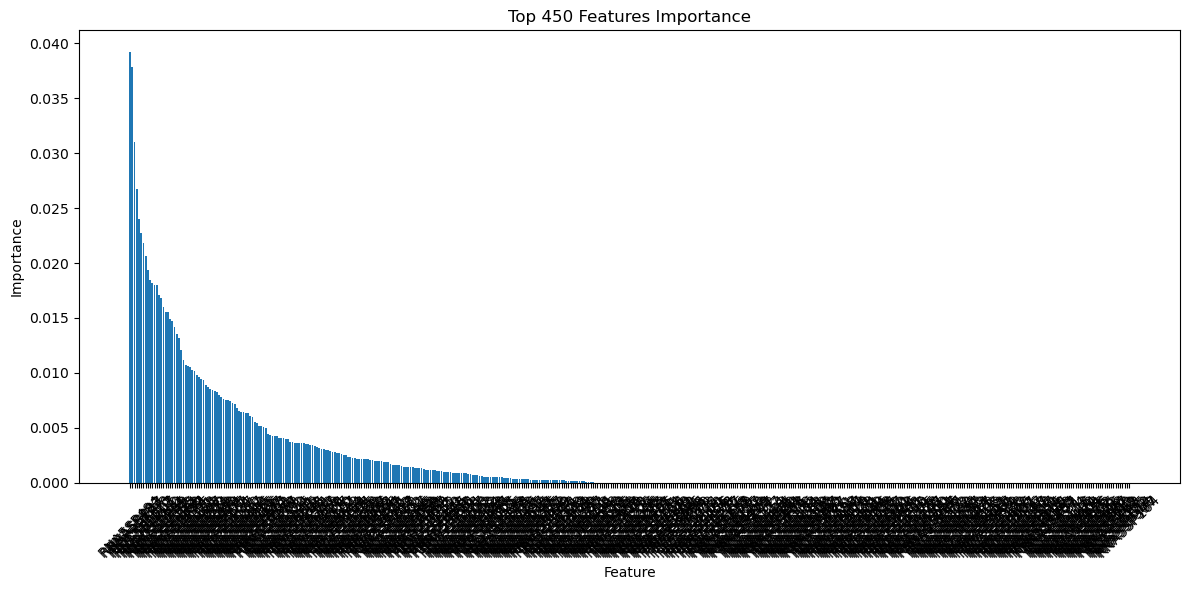

Last important feature:  209


In [11]:
df = pd.read_csv("../Datasets/Dataset16/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [450]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [12]:
df = pd.read_csv("../Datasets/Dataset16/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset16/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [13]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset16/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset16/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [06:41<00:00,  2.81s/ feature counts]


In [14]:
df = pd.read_csv("../Datasets/Dataset16/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0  Naive Bayes             51       0.7655 +/- 0.0402
1  Naive Bayes             52       0.7655 +/- 0.0402
2  Naive Bayes             53       0.7655 +/- 0.0402
3  Naive Bayes             45       0.7655 +/- 0.0402
4  Naive Bayes             43       0.7586 +/- 0.0488
5  Naive Bayes             42       0.7586 +/- 0.0488
6  Naive Bayes             49       0.7586 +/- 0.0488
7  Naive Bayes             54       0.7586 +/- 0.0488
8  Naive Bayes             55       0.7586 +/- 0.0488
9  Naive Bayes             56       0.7586 +/- 0.0378

### Check Distributions

In [17]:
feature_count = 51

data = pd.read_csv(
    f'../Datasets/Dataset16/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

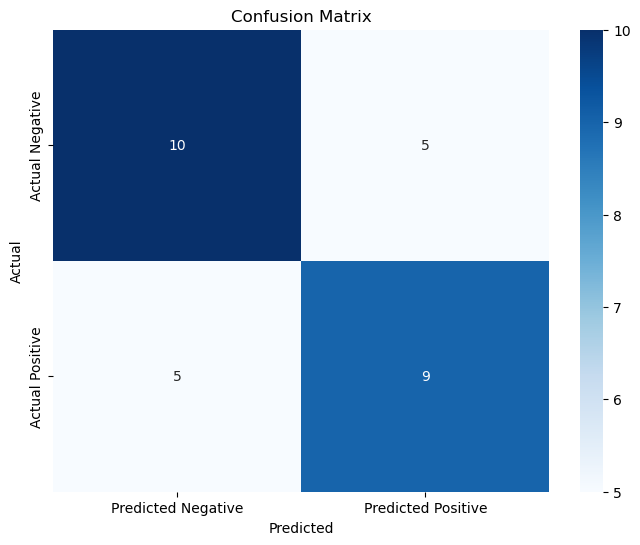

Accuracy: 0.66
Precision: 0.64
Recall (Sensitivity): 0.64
Specificity: 0.67
F1 Score: 0.64


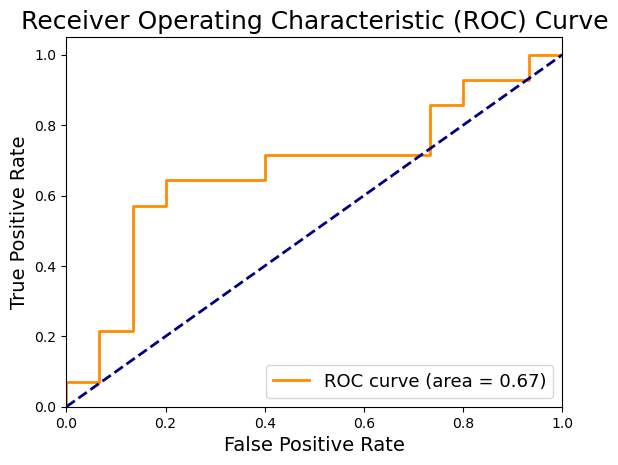

In [18]:
# feature_count = 43

df = pd.read_csv(
    f'../Datasets/Dataset16/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()